In [1]:
!pip install ripser

     |████████████████████████████████| 72 kB 270 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.1 MB/s 
  Created wheel for ripser: filename=ripser-0.6.1-cp37-cp37m-linux_x86_64.whl size=455257 sha256=0794b6ce6bc4558df1bd4431ce19d18fed2e16b1d8efe13641e6cbc4f829de26
  Stored in directory: /root/.cache/pip/wheels/6b/e3/c8/209a9df47cc9af8c6d2dbee4db558dc129494d3f4fbd670285
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18119 sha256=09de35bfa5577a1833c641926fef4735454f8adfa17c90f54d6319f1cff476e4
  Stored in directory: /root/.cache/pip/wheels/d2/9f/a8/67f1b86e47cd17338d3d07939f4660378e65b758c4594f96e3
Successfully built ripser hopcroftkarp


# Geometry of Sliding Window Embeddings
In this module, you will interactively explore how various parameters of sliding window embeddings of 1 dimensional periodic time series data affect the geometry of their embeddings.  In each code box, press *ctrl-enter* (or *cmd-enter* on a Mac) to execute the code. Progress through the lab sequentially. As you examine the plots in each experiment, answer the questions that follow.

This first box imports all of the necessary Python packages to run the code in this module. There will be a similar box at the beginning of every module in this series.

In [2]:
#Do all of the imports and setup inline plotting
import numpy as np
from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.io.wavfile


import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

## Sliding Window Code
The code below performs a sliding window embedding on a 1D signal.  The parameters are as follows:

| | |
|:-:|---|
|$x$   | The 1-D signal (numpy array)   |
|dim|The dimension of the embedding|
|$\tau$   | The skip between samples in a given window  |
|$dT$   | The distance to slide from one window to the next  |

That is, along the signal given by the array $x$, the first three windows will will be $$\begin{bmatrix} x(\tau)\\ x(2\tau) \\ \ldots \\ x((\mbox{dim}-1)\cdot\tau)\end{bmatrix},  \begin{bmatrix} x(dT + \tau)\\ x(dT +2\tau) \\ \ldots \\ x(dT +(\mbox{dim}-1)\cdot\tau)\end{bmatrix},  \begin{bmatrix} x(2dT + \tau)\\ x(2dT +2\tau) \\ \ldots \\ x(2dT +(\mbox{dim}-1)\cdot\tau)\end{bmatrix}$$

Spline interpolation is used to fill in information between signal samples, which is necessary for certain combinations of parameters, such as a non-integer $\tau$ or $dT$.

The function *getSlidingWindow* below creates an array $X$ containing the windows as its columns.

In [3]:
def getSlidingWindow(x, dim, Tau, dT):
    """
    Return a sliding window of a time series,
    using arbitrary sampling.  Use linear interpolation
    to fill in values in windows not on the original grid
    Parameters
    ----------
    x: ndarray(N)
        The original time series
    dim: int
        Dimension of sliding window (number of lags+1)
    Tau: float
        Length between lags, in units of time series
    dT: float
        Length between windows, in units of time series
    Returns
    -------
    X: ndarray(N, dim)
        All sliding windows stacked up
    """
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT))
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim))
    spl = InterpolatedUnivariateSpline(np.arange(N), x)
    for i in range(NWindows):
        idxx = dT*i + Tau*np.arange(dim)
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        # Only take windows that are within range
        if end >= len(x):
            X = X[0:i, :]
            break
        X[i, :] = spl(idxx)
    return X

## Sliding Window

We will now perform a sliding window embedding with various choices of parameters.  [Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) will be performed to project the result down to 2D for visualization.  

The first two eigenvalues computed by PCA will be printed.  The closer these eigenvalues are to each other, the rounder and more close to a circle the 2D projection of the embedding is. A red vertical line will be drawn to show the product of $\tau$ and the dimension, or "extent" (window length).

**An important note:** we choose to project the results to 2D (or later, to 3D). Nothing in particular tells us that this is the best choice of dimension. We merely make this choice to enable visualization. In general, when doing PCA, we want to choose enough eigenvalues to account for a significant portion of [explained variance](https://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained).

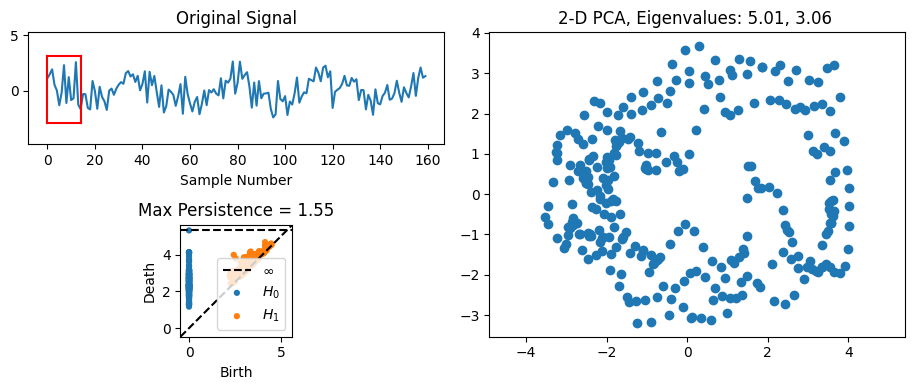

In [4]:
dimsliderval = 20
tausliderval = 1
noiseval = 0
noise = np.random.randn(10000)


def on_value_change(change):

    global dimsliderval
    global tausliderval
    global noiseval

    global dimslider
    global Tauslider
    global noiseampslider

    dimsliderval = dimslider.value
    tausliderval = Tauslider.value
    noiseval = noiseampslider.value

    execute_computation1()

def execute_computation1():
    global dimsliderval
    global tausliderval
    global noiseval

    global dimslider
    global Tauslider
    global noiseampslider

    clear_output(wait=True)

    dimslider = widgets.IntSlider(min=1,max=100,value=dimsliderval,description='Dimension:',continuous_update=False)
    dimslider.observe(on_value_change, names='value')

    Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=tausliderval,description=r'\(\tau :\)' ,continuous_update=False)
    Tauslider.observe(on_value_change, names='value')

    noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=noiseval,description='Noise Amplitude',continuous_update=False)
    noiseampslider.observe(on_value_change, names='value')

    fig = plt.figure(figsize=(9.5, 4))

    display(widgets.HBox(( dimslider,Tauslider, noiseampslider)))

    plt.clf()
    # Step 1: Setup the signal
    T = 40 # The period in number of samples
    NPeriods = 4 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t) # The final signal
    x += noiseampslider.value * noise[:len(x)]

    # Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.5
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    # Step 3: Do Rips Filtration
    PDs = ripser(X, maxdim=1)['dgms']
    I = PDs[1]

    # Step 4: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Step 5: Plot original signal, 2-D projection, and the persistence diagram
    gs = gridspec.GridSpec(2, 2)
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    ax.set_ylim((2*min(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')     
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')

    ax2 = plt.subplot(gs[1,0])
    plot_diagrams(PDs)
    plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))

    ax3 = plt.subplot(gs[:,1])
    ax3.scatter(Y[:, 0], Y[:, 1])
    plt.axis('equal')
    plt.title("2-D PCA, Eigenvalues: %.3g, %.3g "%(eigs[0],eigs[1]))

    plt.tight_layout()
  
execute_computation1()

### Questions
1. For fixed $\tau$:
  1. What does varying the dimension do to the *extent* (the length of the window)?
  1. what dimensions give eigenvalues nearest each other? (Note: dimensions! Plural!) Explain why this is the case. Explain how you might use this information to deduce the period of a signal.
<br><br>
1. What does varying $dT$ do to the PCA embedding? Explain this in terms of the definition of sliding windows above.
<br><br>
1. The command 
```python
np.random.randn(pts)
```
generates an array of length *pts* filled with random values drawn from a standard normal distribution ($\mu=0$, $\sigma=1$). Modify the code above to add random noise to signal. 
  1. Can you still detect the period visually by inspecting the plot of the signal?
  1. Does your method of detecting the period from the first question still work?
  1. How does adding noise change the geometry of the PCA embedding? 
  1. Modify the amplitude of the noise (for example, by multiplying the noise-generating command by a constant) and examine the 2D projection. What feature of the 2D projection appears to imply that the signal is periodic? At what noise amplitude does this feature appear to vanish?




## Questions
1. Examining the effect of window extent on maximal persistence (with no noise):
  1. Describe the effect of dimension and $\tau$ on maximal persistence. What does increasing one of these factors while keeping the other constant to do the window extent? What does it do to the maximal persistence? Explain your observations.
  1. Is the maximal persistence a function of the window extent? Justify your answer and explain it geometrically (you may want to refer to the PCA projection plots).
  1. Describe the relation between the eigenvalues and the maximal persistence. (Hint: How do the eigenvalues affect roundness? How does roundness affect persistence?)
  1. Write code to plot scatter plots of maximal persistence vs dimension for fixed $\tau$ and vs $\tau$ for fixed dimension, and maximal persistence vs. dimension for fixed extent (say, extent = 40). Comment on your results.
<br><br>
1. Now add some noise to your plots. Notice that the maximal persistence point on the persistence diagram is colored in red.
  1. What do you observe regarding the persistence diagram? Explain your observations in terms of your understading of persistence.
  1. At what noise amplitude does the point with maximal persistence appear to get 'swallowed up' by the noise in the diagram? How does this correspond with the 2-D projection?
  1. Note that the original signal has amplitude 1. As you increase noise, is it clear by looking at the signal that there is a periodic function underlying it? How does persistence allow detection of periodicity? Explain.
  1. For fixed noise amplitude (say 1), increase dimension. What effect does this have on detection of periodicity using your method?
  1. Does varying $\tau$ for the same fixed amplitude have the same effect? Explain.

## Multiple Sines Sliding Window
We will now go back to periodic signals, but this time we will increase the complexity by adding two sines together.  If the ratio between the two sinusoids is a rational number, then they are called *harmonics* of each other.  For example, $\sin(t)$ and $\sin(3t)$ are harmonics of each other. By contrast, if the ratio of the two frequencies is irrational, then the sinusoids are called *incommensurate*.  For example, $\sin(t)$ and $\sin(\pi t)$ are incommensurate.

The plots below are initialized with 

$$f(t) = \sin(\omega t) + \sin(3\omega t),$$

a sum of two harmonics.  

This time, the eigenvalues of PCA will be plotted (up to the first 10), in addition to the red line showing the extent of the window.  Also, 3D PCA will be displayed instead of 2D PCA, and you can click and drag your mouse to view it from different angles.  Colors will be drawn to indicate the position of the window in time, with cool colors (greens and yellows) indicating earlier windows and hot colors (oranges and reds) indicating later windows (using the "jet" colormap).

## Questions

1. Comment on the relationship between the eigenvalues and the extent (width) of the window.
<br><br>
1. When are the eigenvalues near each other? When are they not?
<br><br>
1. Comment on the change in geometry when the second sinusoid is incommensurate to the first. Specifically, comment on the *intrinsic dimension* of the object in the projection. Can you name the shape in the 3-D projection in the incommensurate case?
<br><br>
1. Try adding noise in like you did in the single frequency case. 
  1. Can you distinguish in the projection between the incommensurate case and the noisy, but harmonic one with second frequency 3? Explain.
  1. What can you say about the eigenvalues in the two cases? Explain your answer.

It seems reasonable to ask what the ideal dimension to embed into is. While that question may be answerable, it would be better to bypass the question altogether. Similarly, it seems that beyond detecting the largest period, these tools are limited in detecting the secondary ones. Topological tools that we will see beginning in the next lab will allow us to make some progress toward that goal.

## Two Sines

Now let's examine the persistent homology of a signal consisting of the sum of two sinusoids.  First, setup and examine the signal.  We will use a slightly coarser sampling rate than we did in the first module to keep the persistent homology code running quickly.

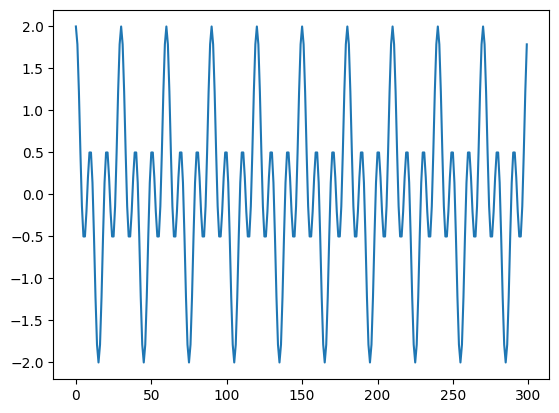

In [ ]:
# Step 1: Setup the signal
T1 = 10 # The period of the first sine in number of samples
T2 = T1*3 # The period of the second sine in number of samples
NPeriods = 10 # How many periods to go through, relative to the second sinusoid
N = T2*NPeriods # The total number of samples
t = np.arange(N) # Time indices
x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
x += np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid
plt.figure();
plt.plot(x);

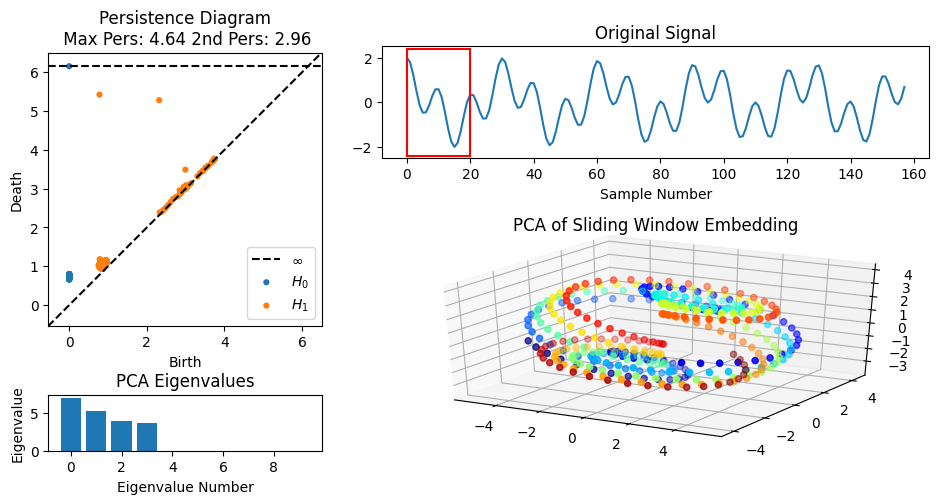

In [5]:
secondfreqval = 3
dimsliderval = 20
tausliderval = 1
noiseval = 0


def on_value_change(change):
    global dimsliderval
    global tausliderval
    global noiseval
    global secondfreqval

    global dimslider
    global Tauslider
    global noiseampslider
    global secondfreq

    dimsliderval = dimslider.value
    tausliderval = Tauslider.value
    noiseval = noiseampslider.value
    secondfreqval = secondfreq.value

    execute_computation3()


noise = np.random.randn(10000)


def execute_computation3():
    global dimsliderval
    global tausliderval
    global noiseval
    global secondfreqval

    global dimslider
    global Tauslider
    global noiseampslider
    global secondfreq

    clear_output(wait=True)

    fig = plt.figure(figsize=(9.5, 5))

    secondfreq = widgets.Dropdown(options=[ 2, 3, np.pi],value=secondfreqval,description='Second Frequency:',disabled=False)
    secondfreq.observe(on_value_change,names='value')

    noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=noiseval,description='Noise Amplitude',continuous_update=False)
    noiseampslider.observe(on_value_change, names='value')

    dimslider = widgets.IntSlider(min=1,max=100,value=dimsliderval,description='Dimension:',continuous_update=False)
    dimslider.observe(on_value_change, names='value')

    Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=tausliderval,description=r'\(\tau :\)' ,continuous_update=False)
    Tauslider.observe(on_value_change, names='value')

    display(widgets.HBox(( dimslider,Tauslider)))
    display(widgets.HBox(( secondfreq,noiseampslider)))

    # Step 1: Setup the signal
    T1 = 10 # The period of the first sine in number of samples
    T2 = T1*secondfreq.value # The period of the second sine in number of samples
    NPeriods = 5 # How many periods to go through, relative to the second sinusoid
    N = T2*NPeriods # The total number of samples
    t = np.arange(N) # Time indices
    x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
    x += np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid
    x += noiseampslider.value * noise[:len(x)]

    #Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.35
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Do Rips Filtration
    PDs = ripser(X, maxdim=1)['dgms']

    #Step 4: Perform PCA down to 2D for visualization
    pca = PCA()
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    #Step 5: Plot original signal and the persistence diagram
    gs = gridspec.GridSpec(3, 2,width_ratios=[1, 2],height_ratios=[2,2,1])
    
    ax = plt.subplot(gs[0,1])
    ax.plot(x)
    ax.set_ylim((1.25*min(x), 1.25*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    yr = np.max(x)-np.min(x)
    yr = [np.min(x)-0.1*yr, np.max(x)+0.1*yr]
    ax.plot([extent, extent], yr, 'r')
    ax.plot([0, 0], yr, 'r')     
    ax.plot([0, extent], [yr[0]]*2, 'r')
    ax.plot([0, extent], [yr[1]]*2, 'r')

    ax2 = plt.subplot(gs[0:2,0])
    plot_diagrams(PDs)
    maxind = np.argpartition(PDs[1][:,1]-PDs[1][:,0], -2)[-2:]
    max1 = PDs[1][maxind[1],1] -  PDs[1][maxind[1],0]
    max2 = PDs[1][maxind[0],1] -  PDs[1][maxind[0],0]
    ax2.set_title("Persistence Diagram\n Max Pers: %.3g 2nd Pers: %.3g"%(max1,max2) )

    ax3 = plt.subplot(gs[2,0])
    eigs = eigs[0:min(len(eigs), 10)]
    ax3.bar(np.arange(len(eigs)), eigs)
    ax3.set_xlabel("Eigenvalue Number")
    ax3.set_ylabel("Eigenvalue")
    ax3.set_title("PCA Eigenvalues")

    c = plt.get_cmap('jet')
    C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
    C = C[:, 0:3]
    ax4 = fig.add_subplot(gs[1:,1], projection = '3d')
    ax4.set_title("PCA of Sliding Window Embedding")
    ax4.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
    #ax4.set_aspect('equal', 'datalim')
    plt.tight_layout()

execute_computation3()

#### Questions

1. Describe a key difference in the persistence diagrams between the harmonic and non-commensurate cases. Explain this difference in terms of the 3-D projection of the PCA embedding. (Hint: consider the shape and the intrinsic dimension of the projection.)
<br><br>
1. Explain how the persistence diagram allows the detection of non-commensurate sinusoids.
<br><br>
1. Can the persistence diagram distinguish between a single sinusoid and the sum of two harmonic sinusoids?
<br><br>
1. Looking back at the 2-D projection of the PCA in the harmonic case from the first lab, explain why the persistence diagram might be surprising if you had only seen that projection. How does looking at the 3-D projection make the persistence diagram less of a surprise?

## Power Spectrum

We saw above that for a rather subtle change in frequency changing the second sinusoid from harmonic to noncommensurate, there is a marked change in the geometry.  By contrast, the power spectral density functions are very close between the two, as shown below.  Hence, it appears that geometric tools are more appropriate for telling the difference between these two types of signals

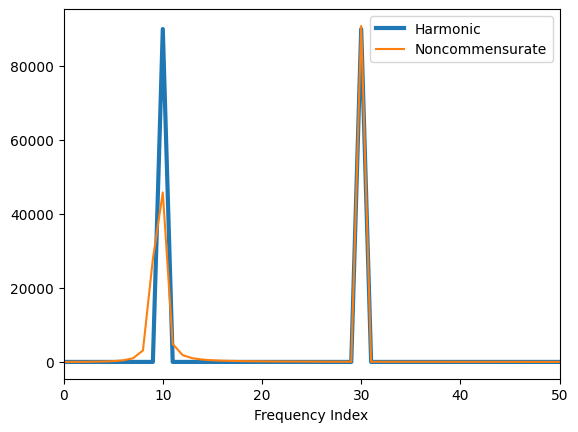

In [6]:
T = 20 #The period of the first sine in number of samples
NPeriods = 10 #How many periods to go through, relative to the faster sinusoid
N = T*NPeriods*3 #The total number of samples
t = np.arange(N) #Time indices

#Make the harmonic signal cos(t) + cos(3t)
xH = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(3*T)*t))
                                        
#Make the incommensurate signal cos(t) + cos(pi*t)
xNC = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(np.pi*T)*t))

plt.figure()
P1 = np.abs(np.fft.fft(xH))**2
P2 = np.abs(np.fft.fft(xNC))**2
plt.plot(np.arange(len(P1)), P1,linewidth=3)
plt.plot(np.arange(len(P2)), P2)
plt.xlabel("Frequency Index")
plt.legend({"Harmonic", "Noncommensurate"})
plt.xlim([0, 50])
plt.show();

<h1>Biphonation Overview</h1>

Biphonation refers to the presence of two or more simultaneous frequencies in a signal which are "incommensurate"; that is, their frequencies are linearly independent over the rational numbers.  In other words, the frequencies are "inharmonic."  We saw a synthetic example in class 1 of cos(x) + cos(pi x).  Today, we will examine how this manifests itself in biology with horse whinnies that occur during states of high emotional valence.  During the steady state of a horse whinnie, biphonation is found

<!--<iframe width="560" height="315" src="https://www.youtube.com/embed/f8DdGpHkzu4" frameborder="0" allowfullscreen></iframe>!-->
<BR><BR>
<h1>Biphonation Example with Horse Whinnies</h1><BR>

Let's now load the audio from the horse whinnie example, interactively plot the audio waveform, and listen to it.

In [8]:
! wget https://github.com/ctralie/TDALabs/blob/master/horsewhinnie.wav?raw=true -O horsewhinnie.wav

--2021-11-05 14:45:04--  https://github.com/ctralie/TDALabs/blob/master/horsewhinnie.wav?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ctralie/TDALabs/raw/master/horsewhinnie.wav [following]
--2021-11-05 14:45:04--  https://github.com/ctralie/TDALabs/raw/master/horsewhinnie.wav
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ctralie/TDALabs/master/horsewhinnie.wav [following]
--2021-11-05 14:45:04--  https://raw.githubusercontent.com/ctralie/TDALabs/master/horsewhinnie.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 20

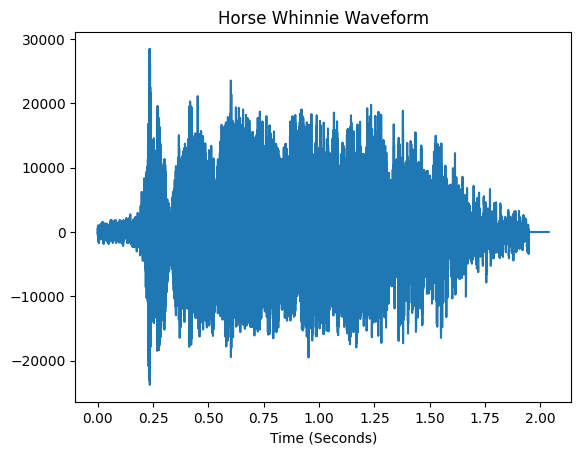

In [9]:
#Read in the audio file.  Fs is the sample rate, and
#X is the audio signal
Fs, X = scipy.io.wavfile.read("horsewhinnie.wav")
plt.figure()
plt.plot(np.arange(len(X))/float(Fs), X)
plt.xlabel("Time (Seconds)")
plt.title("Horse Whinnie Waveform")
plt.show()

from IPython.display import Audio
# load a remote WAV file
Audio('horsewhinnie.wav')

The code below will extract a subsection of the signal and perform a sliding window embedding + 1D persistent homology.  Using the interactive plot of the audio waveform above, find two different time ranges to plot:<BR>

<ol>
<li>A region with a pure tone (single sinusoid), which can be found towards the beginning</li>
<li>A region with biphonation, which can be found towards the middle.  Ensure that this region has two strongly persistent classes with early birth times.  The class will compete to find the region which shows biphonation the most clearly with these statistics, and the score will be based on the <i>second largest persistence</i>, which will be indicated in the persistence diagram plot<BR></li>
</ol>
Modify the "time" variable in the code below accordingly, and run it.

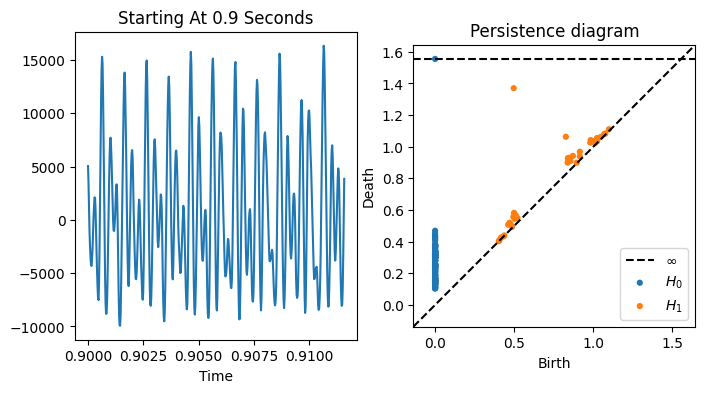

In [11]:
#These variables are used to adjust the window size
F0 = 493 #First fundamental frequency
G0 = 1433 #Second fundamental frequency

###TODO: Modify this variable (time in seconds)
time = 0.9

#Step 1: Extract an audio snippet starting at the chosen time
SigLen = 512 #The number of samples to take after the start time
iStart = int(round(time*Fs))
x = X[iStart:iStart + SigLen]
W = int(round(Fs/G0))

#Step 2: Get the sliding window embedding
Y = getSlidingWindow(x, W, 2, 2)
#Mean-center and normalize
Y = Y - np.mean(Y, 1)[:, None]
Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]

#Step 3: Do the 1D rips filtration
PDs = ripser(Y, maxdim=1)['dgms']
PD = PDs[1]

#Step 4: Figure out the second largest persistence
sP = 0
sPIdx = 0
if PD.shape[0] > 1:
    Pers = PD[:, 1] - PD[:, 0]
    sPIdx = np.argsort(-Pers)[1]
    sP = Pers[sPIdx]
    
#Step 5: Plot the results
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Starting At %g Seconds"%time)
plt.plot(time + np.arange(SigLen)/Fs, x)
plt.xlabel("Time")
plt.subplot(122)
plot_diagrams(PDs)
_ = plt.title("Persistence diagram")

In [ ]:

def PD1SlidingWindow(time, length_frames = 512) :
  SigLen = length_frames #The number of samples to take after the start time
  iStart = int(round(time*Fs))
  x = X[iStart:iStart + SigLen]
  W = int(round(Fs/G0))
  Y = getSlidingWindow(x, W, 2, 2)
  Y = Y - np.mean(Y, 1)[:, None]
  Y = Y/np.sqrt(np.sum(Y**2, 1))[:, None]
  PDs = ripser(Y, maxdim=1)['dgms']
  
  return PDs[1]


def plotProminenceVineyard(pds, n_parameters, initial_parameter, final_parameter, s = 5, y_lim = None, log = False, height = 2, width = 3, decimals = 2):

  def prominences(bd) :
    TOL = 1e-15 ; INF = 1e15
    pers = np.abs(bd[:,0] - bd[:,1])
    pers = pers[pers > TOL]
    pers = pers[pers < INF]
    return pers

  def secondProminence(bd):
    pers = np.abs(bd[:,0] - bd[:,1])
    if len(pers) <= 1:
      return 0
    else :
      return np.partition(pers, -2)[-2]

  pr = [ prominences(pd) for pd in pds]
  #pr = [ [secondProminence(pd)] for pd in pds]
  

  prominence_points = []
  for i in range(n_parameters) :
    for y in pr[i] :
      prominence_points.append([i,y])
  prominence_points = np.array(prominence_points)

  fig1, ax1 = plt.subplots() ; fig1.set_figheight(height) ; fig1.set_figwidth(width) ; plt.xlabel("density threshold")
  plt.ylabel("prominences")
  if y_lim is not None:
    _ = plt.ylim(y_lim)
  _ = plt.xlim([0,n_parameters])

  if log :
    ax1.set_yscale('log')
  
  _ = plt.xticks(np.linspace(0, n_parameters, num=4), np.rint((10**decimals)*np.linspace(initial_parameter, final_parameter, num=4))/(10**decimals))
  _ = plt.scatter(prominence_points.T[0], prominence_points.T[1], s = s, alpha = 1, zorder=2, rasterized = True)

  plt.show()

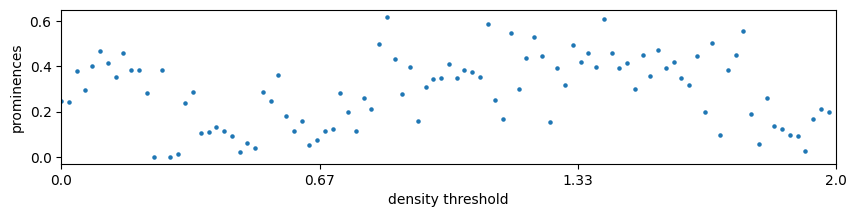

In [ ]:
n_params = 100
start = 0
end = 2

pds = [PD1SlidingWindow(time, length_frames=256) for time in np.linspace(start,end,n_params)]
plotProminenceVineyard(pds,n_params, start, end, width=10)

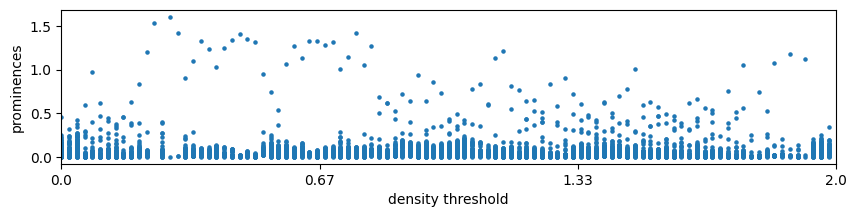

In [ ]:
plotProminenceVineyard(pds,n_params, start, end, width=10)